# Importing libs

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
import random
import scikit_posthocs as sp
import scipy.stats as stats
from scipy.stats import friedmanchisquare
from scipy.stats import kruskal
import pickle
import seaborn as sns
import Orange

In [2]:
monolithic_models_names = ['SVM_lin', 'SVM_RBF', 'KNN', 'GNB', 'GLVQ', 'LDA', 'QDA', 'GP', 'DT', 'Percep', 'MLP']
ensemble_models_names = ['RF', 'XGBoost', 'AdaBoost', 'Bagging', 'OLA', 'LCA', 'MCB', 'KNORAE', 'KNORAU']

# Loading the results

In [3]:
# First, let's load the results CSV file into a dataframe.
# Choose one of the two lines below (monolithic/ensemble):
#results_df, models_names, models_type = pd.read_csv('../Results/results_monolithic.csv'), monolithic_models_names, 'monolithic'
results_df, models_names, models_type = pd.read_csv('../Results/results_ensemble.csv'), ensemble_models_names, 'ensemble'
ds_names = list(results_df['Dataset'].unique())
print(f"Loaded results for {len(models_names)} {models_type} models comprising {len(results_df['Dataset'].unique())} datasets.")

Loaded results for 9 ensemble models comprising 82 datasets.


# Answer to RQ1 and RQ2

**RQ1: Does the choice of  scaling  techniques matters for classification performance?**

For each dataset, we compared the classification performances of each model  when  they  were  trained  with  the  five  scaled copies of the dataset and the baseline,  which is the original dataset.  We then applied a hypothesis test (Friedman) to evaluate the statistical significance of the differences presented.

**RQ2: Which models present greater performance variations when imbalanced data is scaled with different techniques?** 

No additional procedures, graphs and tables were needed to answer this question.

Defining functions to create tables to better visualize the data:

In [4]:
def calculate_summary_of_wins(table):
    col_indexes = {'acc':[1, 2, 3, 4, 5, 6], 
                   'recall':[7, 8, 9, 10, 11, 12], 
                   'precision': [13, 14, 15, 16, 17, 18],
                   'f1':[19, 20, 21, 22, 23, 24],
                   'gmean':[25, 26, 27, 28, 29, 30]
                  }
    list_for_last_line = []
    for mt in ['acc', 'recall', 'precision', 'f1', 'gmean']:
        cnts = {'NS':0, 'SS':0, 'MM':0, 'MA':0, 'RS': 0, 'QT':0}
        for row in range(len(ds_names)): 
            mt_values  = table.iloc[row, col_indexes[mt]].values
            best = max(mt_values)
            pos = [] #indexes of all values equal to best
            for i in range(len(mt_values)):
                if mt_values[i] == best:
                    pos.append(i)
            for p in pos:
                best_st = list(cnts.keys())[p] #best scaling technique.
                cnts[best_st] += 1/len(pos) #give each best scal technique its corresponding fraction.
        list_for_last_line += list(cnts.values())
    return ['total wins']+list_for_last_line
                   
                   
def calculate_summary_of_wins_per_IR_level(table, level):
    if level == 'low':
        lvl_range = range(0,11)
    elif level == 'medium':
        lvl_range = range(11,22)
    elif level == 'high':
        lvl_range = range(22, 82)
    else:
        print('Level not supported, choose one of: low, medium, high')
    col_indexes = {'acc':[1, 2, 3, 4, 5, 6], 
                   'recall':[7, 8, 9, 10, 11, 12], 
                   'precision': [13, 14, 15, 16, 17, 18],
                   'f1':[19, 20, 21, 22, 23, 24],
                   'gmean':[25, 26, 27, 28, 29, 30]
                  }
    list_for_last_line = []
    for mt in ['acc', 'recall', 'precision', 'f1', 'gmean']:
        cnts = {'NS':0, 'SS':0, 'MM':0, 'MA':0, 'RS': 0, 'QT':0}
        for row in lvl_range:
            mt_values  = table.iloc[row, col_indexes[mt]].values
            best = max(mt_values)
            pos = [] #indexes of all values equal to best
            for i in range(len(mt_values)):
                if mt_values[i] == best:
                    pos.append(i)
            for p in pos:
                best_st = list(cnts.keys())[p] #best scaling technique.
                cnts[best_st] += 1/len(pos) #give each best scal technique its corresponding fraction.
        list_for_last_line += list(cnts.values())
    return ['total wins - '+level]+list_for_last_line

## Analysis for the low IR (virtually imbalanced) datasets

First let's make an analysis considering the datasets with IR levels under 3. This will serve as a baseline or control group.

In [5]:
results_df_means = results_df[['Dataset', 'Scaling technique', 'Model', 'acc_mean', 'recall_mean',
                               'precision_mean', 'f1_mean', 'gmean_mean']]

low_IR_ds_names = ['glass1-5-fold', 'ecoli-0_vs_1-5-fold', 'wisconsin-5-fold', 'pima-5-fold',
                   'iris0-5-fold', 'glass0-5-fold', 'yeast1-5-fold', 'haberman-5-fold',
                   'vehicle2-5-fold', 'vehicle1-5-fold', 'vehicle3-5-fold']
results_df_means_low_IR = results_df_means[results_df_means['Dataset'].isin(low_IR_ds_names)]

In [6]:
rfm_dict_low_IR= {}

for model in models_names: 
    #Filtering results by model:
    rfm = results_df_means[results_df_means['Model'].eq(model)]
    rfm_dict_low_IR[model] = rfm

"""
   |   resultados F1  ||  resultados AUC ||resultados g-mean|
BD | NS SS MM MA RS   ||  NS SS MM MA RS ||  NS SS MM MA RS |
"""
scal_techs = [('No scaling', 'NS'), ('Standard Scaler', 'SS'), 
              ('Min-Max Scaler', 'MM'), ('Max Abs Scaler', 'MA'), 
              ('Robust Scaler','RS'), ('Quantile Transformer', 'QT')]

results_by_model_dict_low_IR = {}
for model in models_names:
    #print(model)
    new_table = pd.DataFrame()
    df = rfm_dict_low_IR[model]
    df = df[df['Scaling technique'].eq('No scaling')].reset_index()[['Dataset']]
    new_table = pd.concat([new_table, df], axis=1)
    for mt, m_short in [('acc_mean', 'acc'), ('recall_mean','recall'), ('precision_mean', 'precision'), 
                        ('f1_mean', 'f1'), ('gmean_mean', 'gmean')]:
        for st, st_short in scal_techs:
            df = rfm_dict_low_IR[model]
            df = df[df['Scaling technique'].eq(st)].reset_index()[[mt]]
            df = df.rename(columns={mt: m_short+' - '+st_short})
            new_table = pd.concat([new_table, df], axis=1)
    # adding summary line
    new_table.loc[len(ds_names)] = calculate_summary_of_wins(new_table)
    new_table.to_csv('csv_tabs_'+models_type+'/'+model+'_low_IR.csv', index=False, float_format='%.3f')
    results_by_model_dict_low_IR[model] = new_table

In [8]:
# Creating a summary table that shows the means of metrics (for all DSs) 
# and total wins for each model (lines) and each pair metric-st (columns)

dfs = []
for model in models_names:
    df = results_by_model_dict_low_IR[model]
    model_means_dict = df.iloc[:-4,:].mean().to_dict()
    dfs.append(pd.DataFrame(data = model_means_dict, index=[model+' - means']))
    #Adding line presenting total wins for each scaling technique after each model mean:
    df_total_wins = df[df['Dataset'].eq('total wins')]
    df_total_wins.index=[model+'- Total wins']
    df_total_wins = df_total_wins.drop(columns=['Dataset'])
    dfs.append(df_total_wins)

summary_df_low_IR = pd.concat(dfs)
new_col = ['means', 'Total wins']*len(models_names)
summary_df_low_IR.insert(0, '', new_col, allow_duplicates=True)
#Calculating overall mean of each column:
means_df = summary_df_low_IR[summary_df_low_IR[''].eq('means')]
means_df = means_df[means_df.columns[1:]]
overall_means_df = pd.DataFrame(dict(means_df.mean()), index=['Overall mean'])
#Calculating overall sum of wins of each column:
wins_df = summary_df_low_IR[summary_df_low_IR[''].eq('Total wins')]
wins_df = wins_df[wins_df.columns[1:]]
overall_wins_df = pd.DataFrame(dict(wins_df.sum()), index=['Overall sum of wins'])

#Adding last two lines (Overall mean and overall wins):
summary_df_low_IR = pd.concat([summary_df_low_IR, overall_means_df, overall_wins_df])

# Selecting only F1 and G-mean:
indexes = [0]+list(range(19,31))
summary_df_low_IR = summary_df_low_IR[summary_df_low_IR.columns[indexes]]

# Saving table as CSV:
summary_df_low_IR.to_csv('csv_tabs_'+models_type+'/summary_'+models_type+'_low_IR.csv', index=True, float_format='%.2f')

<ipython-input-8-99b8cacfdae5>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  model_means_dict = df.iloc[:-4,:].mean().to_dict()


### Significance Test (Friedman)

Here we test the significance of the differences between the values of a certain metric considering the different Scaling Techniques for a certain model. 

In [9]:
#!pip install scikit_posthocs
def test_significance(metric_name, rfm):
    group_ns = rfm[rfm['Scaling technique'].eq('No scaling')][metric_name]
    group_ss = rfm[rfm['Scaling technique'].eq('Standard Scaler')][metric_name]
    group_mms = rfm[rfm['Scaling technique'].eq('Min-Max Scaler')][metric_name]
    group_mas = rfm[rfm['Scaling technique'].eq('Max Abs Scaler')][metric_name]
    group_rs = rfm[rfm['Scaling technique'].eq('Robust Scaler')][metric_name]
    group_qt = rfm[rfm['Scaling technique'].eq('Quantile Transformer')][metric_name]

    data = [group_ns, group_ss, group_mms, group_mas, group_rs, group_qt]
    #stat, p = kruskal(*data)
    stat, p = friedmanchisquare(*data)

    #If the null-hypothesis is rejected, we can proceed with a post-hoc test.
    #posthoc = sp.posthoc_nemenyi(data)
    posthoc = sp.posthoc_dunn(data)
    return stat, p, posthoc

In [10]:
test_res_dict = {'Model':[],'Metric':[],'Statistics':[],'p-value':[],'Rejects $H_0$?':[]}

for model in models_names:
    rfm = results_df_means_low_IR[results_df_means_low_IR['Model'].eq(model)]
    # Executing Friedman Chi Square test for each metric:
    #for metric in ['acc_mean', 'recall_mean', 'precision_mean', 'f1_mean', 'gmean_mean']:
    for metric in ['f1_mean', 'gmean_mean']:
        #print('\nFriedman Chi Square test for model '+model+' using '+metric[:-5]+':')
        stat, p, posthoc = test_significance(metric, rfm)
        test_res_dict['Model'].append(model)
        test_res_dict['Metric'].append(metric[:-5])
        test_res_dict['Statistics'].append(stat)
        test_res_dict['p-value'].append(p)
        alpha = 0.05 # Significance level
        if p <= alpha: test_res_dict['Rejects $H_0$?'].append('Yes')
        else: test_res_dict['Rejects $H_0$?'].append('No')
        #ax, cbar = plot(posthoc)
        #plt.show()
        #plt.close('all')
        
test_res_df = pd.DataFrame(test_res_dict)
test_res_df.to_csv('csv_tabs_'+models_type+'/friedman_test_results_low_IR.csv', index=False, float_format='%.4f')
test_res_df

,Model,Metric,Statistics,p-value,Rejects $H_0$?
0,RF,f1,6.215753,0.285788,No
1,RF,gmean,6.969178,0.222943,No
2,XGBoost,f1,9.424084,0.093298,No
3,XGBoost,gmean,9.424084,0.093298,No
4,AdaBoost,f1,6.689189,0.244801,No
5,AdaBoost,gmean,6.689189,0.244801,No
6,Bagging,f1,17.200000,0.004136,Yes
7,Bagging,gmean,19.714286,0.001414,Yes
8,OLA,f1,3.767123,0.583407,No
9,OLA,gmean,3.054795,0.691538,No


### Studying ranges to assess variability

Lets put ranges in a table so we can find a way to compare the variability of monolithic and ensemble models.

In [11]:
summary_df_T = summary_df_low_IR.transpose()
bp_dfs = {} # This will store a dataframe for each model
for model in models_names:
    bp_df = pd.DataFrame()# Creating a DataFrame for the boxplot
    #for m in ['acc', 'recall', 'precision', 'f1', 'gmean']:
    for m in ['f1', 'gmean']:
        m_df = summary_df_T.filter(items = [model+' - means']).filter(like=m, axis=0)
        m_df = m_df.rename(columns={model+' - means':m})
        m_df = m_df.reset_index(drop=True)
        bp_df = pd.concat([bp_df, m_df], axis = 1)
        bp_df = bp_df.apply(pd.to_numeric, errors='raise') #converting back to numeric
    bp_dfs[model] = bp_df

#bp_dfs
#bp_dfs[model].describe().iloc[3,:] # min
# bp_dfs[model].describe().iloc[7,:] # max

var_range = {} # A dict for storing the variation ranges (max minus min) with models as keys 
for model in models_names:
    var_range[model] = bp_dfs[model].describe().iloc[7,:] - bp_dfs[model].describe().iloc[3,:] # max - min

In [12]:
# This table will show the range of each metric for each model, showing the mean range and stddev for each metric as the two last columns.
var_range_df = pd.DataFrame(var_range)
means_df = pd.DataFrame(var_range_df.T.mean().T, columns=['mean'])
stddev_df = pd.DataFrame(var_range_df.T.std().T, columns=['stddev'])
var_range_df_with_mean = pd.concat([var_range_df, means_df, stddev_df], axis = 1)
#var_range_df_with_mean.to_csv('csv_tabs_'+models_type+'/var_range_'+models_type+'.csv', index=True, float_format='%.3f')
pickle_file = open(f'var_range_df_with_mean_{models_type}_low_IR.pickle', 'wb')
pickle.dump(var_range_df_with_mean, pickle_file)
#var_range_df_with_mean


#### Figure: barplot_range_by_model

Now, let's plot these ranges by model:

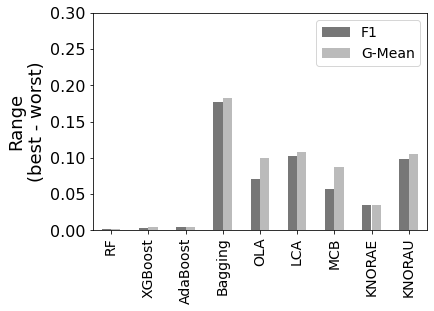

In [13]:
plt.close('all')
rnm = {'f1':'F1', 'gmean':'G-Mean'}
var_range_df.rename(index=rnm).transpose().plot.bar(color=['#777777', '#bbbbbb'])
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=16, rotation=0);
plt.locator_params(nbins=8, axis = 'y')
plt.ylim(0, 0.3)
plt.ylabel('Range\n(best - worst)', size = 18)
plt.legend(fontsize=14)
#plt.savefig('figs_'+models_type+'/barplot_range_by_model_'+models_type+'_low_IR.png', bbox_inches = 'tight')
plt.show()
plt.close('all')

## Analysis for all the datasets (inlcluding all IR levels)

### Analysing the means of each metric

In [14]:
results_df_means = results_df[['Dataset', 'Scaling technique', 'Model', 'acc_mean', 'recall_mean', 'precision_mean',
                               'f1_mean', 'gmean_mean']]
results_df_means.head(8)

,Dataset,Scaling technique,Model,acc_mean,recall_mean,precision_mean,f1_mean,gmean_mean
0,glass1-5-fold,No scaling,RF,0.813178,0.647500,0.796667,0.709950,0.762594
1,glass1-5-fold,Standard Scaler,RF,0.822591,0.660833,0.808485,0.724957,0.774232
2,glass1-5-fold,Min-Max Scaler,RF,0.813178,0.647500,0.796667,0.709950,0.762594
3,glass1-5-fold,Max Abs Scaler,RF,0.817829,0.647500,0.806667,0.715111,0.766009
4,glass1-5-fold,Robust Scaler,RF,0.817829,0.647500,0.806667,0.715111,0.766009
5,glass1-5-fold,Quantile Transformer,RF,0.813178,0.660833,0.789125,0.713577,0.766585
6,ecoli-0_vs_1-5-fold,No scaling,RF,0.990909,1.000000,0.986667,0.993220,0.986437
7,ecoli-0_vs_1-5-fold,Standard Scaler,RF,0.990909,1.000000,0.986667,0.993220,0.986437


In [15]:
rfm_dict= {}

for model in models_names: 
    #Filtering results by model:
    rfm = results_df_means[results_df_means['Model'].eq(model)]
    rfm_dict[model] = rfm

"""
   |   resultados F1  ||  resultados AUC ||resultados g-mean|
BD | NS SS MM MA RS   ||  NS SS MM MA RS ||  NS SS MM MA RS |
"""
scal_techs = [('No scaling', 'NS'), ('Standard Scaler', 'SS'), 
              ('Min-Max Scaler', 'MM'), ('Max Abs Scaler', 'MA'), 
              ('Robust Scaler','RS'), ('Quantile Transformer', 'QT')]

results_by_model_dict = {}
for model in models_names:
    #print(model)
    new_table = pd.DataFrame()
    df = rfm_dict[model]
    df = df[df['Scaling technique'].eq('No scaling')].reset_index()[['Dataset']]
    new_table = pd.concat([new_table, df], axis=1)
    for mt, m_short in [('acc_mean', 'acc'), ('recall_mean','recall'), ('precision_mean', 'precision'), 
                        ('f1_mean', 'f1'), ('gmean_mean', 'gmean')]:
        for st, st_short in scal_techs:
            df = rfm_dict[model]
            df = df[df['Scaling technique'].eq(st)].reset_index()[[mt]]
            df = df.rename(columns={mt: m_short+' - '+st_short})
            new_table = pd.concat([new_table, df], axis=1)
    # adding last 4 lines (summary)
    new_table.loc[len(ds_names)] = calculate_summary_of_wins(new_table)
    new_table.loc[len(ds_names)+1] = calculate_summary_of_wins_per_IR_level(new_table, 'low')
    new_table.loc[len(ds_names)+2] = calculate_summary_of_wins_per_IR_level(new_table, 'medium')
    new_table.loc[len(ds_names)+3] = calculate_summary_of_wins_per_IR_level(new_table, 'high')
    new_table.to_csv('csv_tabs_'+models_type+'/'+model+'.csv', index=False, float_format='%.3f')
    results_by_model_dict[model] = new_table

In [16]:
res_by_mod_dict = {}
for model in models_names:
    res_by_mod_dict[model] = results_by_model_dict[model][['Dataset', 'f1 - NS', 'f1 - SS', 'f1 - MM', 'f1 - MA', 'f1 - RS', 'f1 - QT',
           'gmean - NS', 'gmean - SS', 'gmean - MM', 'gmean - MA', 'gmean - RS',
           'gmean - QT']].iloc[:-4,:]

pickle_file = open(f'res_by_mod_dict_{models_type}.pickle', 'wb')
pickle.dump(res_by_mod_dict, pickle_file)

In [17]:
# Creating a summary table that shows the means of metrics (for all DSs) 
# and total wins for each model (lines) and each pair metric-st (columns)

dfs = []
for model in models_names:
    df = results_by_model_dict[model]
    model_means_dict = df.iloc[:-4,:].mean().to_dict()
    dfs.append(pd.DataFrame(data = model_means_dict, index=[model+' - means']))
    #Adding line presenting total wins for each scaling technique after each model mean:
    df_total_wins = df[df['Dataset'].eq('total wins')]
    df_total_wins.index=[model+'- Total wins']
    df_total_wins = df_total_wins.drop(columns=['Dataset'])
    dfs.append(df_total_wins)

summary_df = pd.concat(dfs)
new_col = ['means', 'Total wins']*len(models_names)
summary_df.insert(0, '', new_col, allow_duplicates=True)
#Calculating overall mean of each column:
means_df = summary_df[summary_df[''].eq('means')]
means_df = means_df[means_df.columns[1:]]
overall_means_df = pd.DataFrame(dict(means_df.mean()), index=['Overall mean'])
#Calculating overall sum of wins of each column:
wins_df = summary_df[summary_df[''].eq('Total wins')]
wins_df = wins_df[wins_df.columns[1:]]
overall_wins_df = pd.DataFrame(dict(wins_df.sum()), index=['Overall sum of wins'])

#Adding last two lines (Overall mean and overall wins):
summary_df = pd.concat([summary_df, overall_means_df, overall_wins_df])

# Selecting only F1 and G-mean:
indexes = [0]+list(range(19,31))
indexes
summary_df = summary_df[summary_df.columns[indexes]]

# Saving table as CSV:
summary_df.to_csv('csv_tabs_'+models_type+'/summary_'+models_type+'.csv', index=True, float_format='%.2f')

<ipython-input-17-410b7e2b8c77>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  model_means_dict = df.iloc[:-4,:].mean().to_dict()


### Significance Test (Friedman)

Here we test the significance of the differences between the values of a certain metric considering the different Scaling Techniques for a certain model. 

In [18]:
#!pip install scikit_posthocs
def test_significance(metric_name, rfm):
    group_ns = rfm[rfm['Scaling technique'].eq('No scaling')][metric_name]
    group_ss = rfm[rfm['Scaling technique'].eq('Standard Scaler')][metric_name]
    group_mms = rfm[rfm['Scaling technique'].eq('Min-Max Scaler')][metric_name]
    group_mas = rfm[rfm['Scaling technique'].eq('Max Abs Scaler')][metric_name]
    group_rs = rfm[rfm['Scaling technique'].eq('Robust Scaler')][metric_name]
    group_qt = rfm[rfm['Scaling technique'].eq('Quantile Transformer')][metric_name]

    data = [group_ns, group_ss, group_mms, group_mas, group_rs, group_qt]
    #stat, p = kruskal(*data)
    stat, p = friedmanchisquare(*data)

    #If the null-hypothesis is rejected, we can proceed with a post-hoc test.(Artigo)
    #posthoc = sp.posthoc_nemenyi(data)
    posthoc = sp.posthoc_dunn(data)
    return stat, p, posthoc

In [19]:
test_res_dict = {'Model':[],'Metric':[],'Statistics':[],'p-value':[],'Rejects $H_0$?':[]}

for model in models_names:
    rfm = results_df_means[results_df_means['Model'].eq(model)]
    # Executing Friedman Chi Square test for each metric:
    #for metric in ['acc_mean', 'recall_mean', 'precision_mean', 'f1_mean', 'gmean_mean']:
    for metric in ['f1_mean', 'gmean_mean']:
        #print('\nFriedman Chi Square test for model '+model+' using '+metric[:-5]+':')
        stat, p, posthoc = test_significance(metric, rfm)
        test_res_dict['Model'].append(model)
        test_res_dict['Metric'].append(metric[:-5])
        test_res_dict['Statistics'].append(stat)
        test_res_dict['p-value'].append(p)
        alpha = 0.05 # Significance level
        if p <= alpha: test_res_dict['Rejects $H_0$?'].append('Yes')
        else: test_res_dict['Rejects $H_0$?'].append('No')
        #ax, cbar = plot(posthoc)
        #plt.show()
        #plt.close('all')
        
test_res_df = pd.DataFrame(test_res_dict)
test_res_df.to_csv('csv_tabs_'+models_type+'/friedman_test_results.csv', index=False, float_format='%.4f')
test_res_df

,Model,Metric,Statistics,p-value,Rejects $H_0$?
0,RF,f1,4.229015,5.169365e-01,No
1,RF,gmean,4.366327,4.979650e-01,No
2,XGBoost,f1,1.062030,9.574091e-01,No
3,XGBoost,gmean,1.062030,9.574091e-01,No
4,AdaBoost,f1,10.171756,7.051235e-02,No
5,AdaBoost,gmean,10.171756,7.051235e-02,No
6,Bagging,f1,81.224182,4.652424e-16,Yes
7,Bagging,gmean,105.077386,4.489081e-21,Yes
8,OLA,f1,12.198165,3.217107e-02,Yes
9,OLA,gmean,20.357012,1.070873e-03,Yes


### Studying ranges to assess variability

Lets put ranges in a table so we can find a way to compare the variability of monolithic and ensemble models.

In [20]:
summary_df_T = summary_df.transpose()
bp_dfs = {} # This will store a dataframe for each model
for model in models_names:
    bp_df = pd.DataFrame()# Creating a DataFrame for the boxplot
    #for m in ['acc', 'recall', 'precision', 'f1', 'gmean']:
    for m in ['f1', 'gmean']:
        m_df = summary_df_T.filter(items = [model+' - means']).filter(like=m, axis=0)
        m_df = m_df.rename(columns={model+' - means':m})
        m_df = m_df.reset_index(drop=True)
        bp_df = pd.concat([bp_df, m_df], axis = 1)
        bp_df = bp_df.apply(pd.to_numeric, errors='raise') #converting back to numeric
    bp_dfs[model] = bp_df

# bp_dfs[model].describe().iloc[3,:] # min
# bp_dfs[model].describe().iloc[7,:] # max

var_range = {} # A dict for storing the variation ranges (max minus min) with models as keys 
for model in models_names:
    var_range[model] = bp_dfs[model].describe().iloc[7,:] - bp_dfs[model].describe().iloc[3,:] # max - min

In [25]:
# This table will show the range of each metric for each model, showing the mean range and stddev for each metric as the two last columns.
var_range_df = pd.DataFrame(var_range)
means_df = pd.DataFrame(var_range_df.T.mean().T, columns=['mean'])
stddev_df = pd.DataFrame(var_range_df.T.std().T, columns=['stddev'])
#var_range_df_with_mean = pd.concat([var_range_df, means_df, stddev_df], axis = 1)
var_range_df_with_mean.to_csv('csv_tabs_'+models_type+'/var_range_'+models_type+'.csv', index=True, float_format='%.3f')
pickle_file = open(f'var_range_df_with_mean_{models_type}.pickle', 'wb')
pickle.dump(var_range_df_with_mean, pickle_file)
pickle.dump(var_range_df_with_mean, pickle_file) # oddly, when running this line only once, the file ends up empty
var_range_df_with_mean


,RF,XGBoost,AdaBoost,Bagging,OLA,LCA,MCB,KNORAE,KNORAU,mean,stddev
f1,0.001791,0.003379,0.005357,0.177663,0.071118,0.102302,0.056599,0.035444,0.098217,0.061319,0.058520
gmean,0.001357,0.004097,0.005069,0.182602,0.099964,0.108487,0.087498,0.034617,0.105607,0.069922,0.062405


#### Figure: barplot_range_by_model

Now, let's plot these ranges by model:

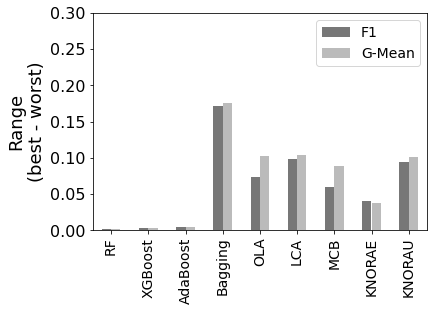

In [26]:
plt.close('all')
rnm = {'f1':'F1', 'gmean':'G-Mean'}
var_range_df.rename(index=rnm).transpose().plot.bar(color=['#777777', '#bbbbbb'])
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=16, rotation=0);
plt.locator_params(nbins=8, axis = 'y')
plt.ylim(0, 0.3)
plt.ylabel('Range\n(best - worst)', size = 18)
plt.legend(fontsize=14)
#plt.savefig('figs_'+models_type+'/barplot_range_by_model_'+models_type+'.png', bbox_inches = 'tight')
plt.show()
plt.close('all')

In [27]:
# Unified barplot for mono and ensemble, run this only after having run the above code for both monolithic and ensemble CSVs.
pickle_file_mono = open('var_range_df_with_mean_monolithic.pickle', 'rb')
var_range_mono = pickle.load(pickle_file_mono)
pickle_file_ensemble = open('var_range_df_with_mean_ensemble.pickle', 'rb')
var_range_ensemble = pickle.load(pickle_file_ensemble)

In [28]:
var_range_all = pd.concat([var_range_mono.iloc[:,:-2], var_range_ensemble.iloc[:,:-2]], axis=1)
var_range_all

,SVM_lin,SVM_RBF,KNN,GNB,GLVQ,LDA,QDA,GP,DT,Percep,MLP,RF,XGBoost,AdaBoost,Bagging,OLA,LCA,MCB,KNORAE,KNORAU
f1,0.164523,0.174074,0.041935,0.012650,0.096202,0.019898,0.040490,0.254147,0.003117,0.151594,0.163327,0.001791,0.003379,0.005357,0.177663,0.071118,0.102302,0.056599,0.035444,0.098217
gmean,0.187276,0.181164,0.038535,0.050681,0.112753,0.023413,0.063974,0.275814,0.003296,0.201750,0.190087,0.001357,0.004097,0.005069,0.182602,0.099964,0.108487,0.087498,0.034617,0.105607


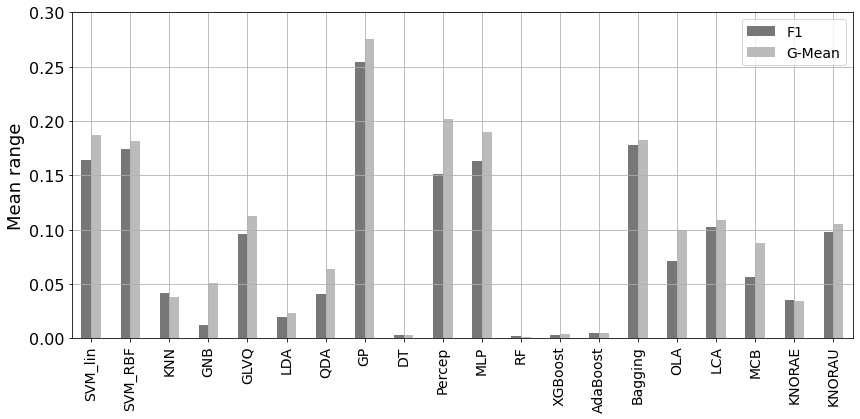

In [29]:
rnm = {'f1':'F1', 'gmean':'G-Mean'}
plt.close('all')
var_range_all.rename(index=rnm).transpose().plot.bar(color=['#777777', '#bbbbbb'])
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=16, rotation=0)
plt.locator_params(nbins=8, axis = 'y')
plt.ylim(0, 0.3)
plt.ylabel('Mean range', size = 18)
plt.legend(fontsize=14)
plt.gcf().set_size_inches(14, 6)
plt.grid()
#plt.savefig('figs/barplot_range_by_model.png', bbox_inches = 'tight')
plt.show()
plt.close('all')

## Significance tests for low, medium and high IR

Let's make an analysis considering the datasets with different IR levels:

- Low: IR <= 3
- Med: 3 < IR <= 9
- High: IR > 9


In [30]:
results_df_means = results_df[['Dataset', 'Scaling technique', 'Model', 'acc_mean', 'recall_mean',
                               'precision_mean', 'f1_mean', 'gmean_mean']]

low_IR_ds_names = ds_names[:11]   #from glass1 to vehicle3
med_IR_ds_names = ds_names[11:22] #from glass-0-1-2-3_vs_4-5-6 to ecoli-0-3-4_vs_5 
high_IR_ds_names = ds_names[22:]  #from yeast-2_vs_4 to abalone19

results_df_means_low_IR = results_df_means[results_df_means['Dataset'].isin(low_IR_ds_names)]
results_df_means_med_IR = results_df_means[results_df_means['Dataset'].isin(med_IR_ds_names)]
results_df_means_high_IR = results_df_means[results_df_means['Dataset'].isin(high_IR_ds_names)]

### Significance Test (Friedman)

Here we test the significance of the differences between the values of a certain metric considering the different Scaling Techniques for a certain model. 

In [31]:
#!pip install scikit_posthocs
def test_significance(metric_name, rfm):
    group_ns = rfm[rfm['Scaling technique'].eq('No scaling')][metric_name]
    group_ss = rfm[rfm['Scaling technique'].eq('Standard Scaler')][metric_name]
    group_mms = rfm[rfm['Scaling technique'].eq('Min-Max Scaler')][metric_name]
    group_mas = rfm[rfm['Scaling technique'].eq('Max Abs Scaler')][metric_name]
    group_rs = rfm[rfm['Scaling technique'].eq('Robust Scaler')][metric_name]
    group_qt = rfm[rfm['Scaling technique'].eq('Quantile Transformer')][metric_name]

    data = [group_ns, group_ss, group_mms, group_mas, group_rs, group_qt]
    #stat, p = kruskal(*data)
    stat, p = friedmanchisquare(*data)

    #If the null-hypothesis is rejected, we can proceed with a post-hoc test.(Artigo)
    #posthoc = sp.posthoc_nemenyi(data)
    posthoc = sp.posthoc_dunn(data)
    return stat, p, posthoc

For low IR datasets:

In [32]:
test_res_dict = {'Model':[],'Metric':[],'Statistics':[],'p-value':[],'Rejects $H_0$?':[]}

for model in models_names:
    rfm = results_df_means_low_IR[results_df_means_low_IR['Model'].eq(model)]
    # Executing Friedman Chi Square test for each metric:
    #for metric in ['acc_mean', 'recall_mean', 'precision_mean', 'f1_mean', 'gmean_mean']:
    for metric in ['f1_mean', 'gmean_mean']:
        #print('\nFriedman Chi Square test for model '+model+' using '+metric[:-5]+':')
        stat, p, posthoc = test_significance(metric, rfm)
        test_res_dict['Model'].append(model)
        test_res_dict['Metric'].append(metric[:-5])
        test_res_dict['Statistics'].append(stat)
        test_res_dict['p-value'].append(p)
        alpha = 0.05 # Significance level
        if p <= alpha: test_res_dict['Rejects $H_0$?'].append('Yes')
        else: test_res_dict['Rejects $H_0$?'].append('No')
        #ax, cbar = plot(posthoc)
        #plt.show()
        #plt.close('all')
        
test_res_low_df = pd.DataFrame(test_res_dict)
#test_res_low_df.to_csv('csv_tabs_'+models_type+'/friedman_test_results_low_IR.csv', index=False, float_format='%.4f')

For med IR datasets:

In [33]:
test_res_dict = {'Model':[],'Metric':[],'Statistics':[],'p-value':[],'Rejects $H_0$?':[]}

for model in models_names:
    rfm = results_df_means_med_IR[results_df_means_med_IR['Model'].eq(model)]
    # Executing Friedman Chi Square test for each metric:
    #for metric in ['acc_mean', 'recall_mean', 'precision_mean', 'f1_mean', 'gmean_mean']:
    for metric in ['f1_mean', 'gmean_mean']:
        #print('\nFriedman Chi Square test for model '+model+' using '+metric[:-5]+':')
        stat, p, posthoc = test_significance(metric, rfm)
        test_res_dict['Model'].append(model)
        test_res_dict['Metric'].append(metric[:-5])
        test_res_dict['Statistics'].append(stat)
        test_res_dict['p-value'].append(p)
        alpha = 0.05 # Significance level
        if p <= alpha: test_res_dict['Rejects $H_0$?'].append('Yes')
        else: test_res_dict['Rejects $H_0$?'].append('No')
        #ax, cbar = plot(posthoc)
        #plt.show()
        #plt.close('all')
        
test_res_med_df = pd.DataFrame(test_res_dict)
#test_res_med_df.to_csv('csv_tabs_'+models_type+'/friedman_test_results_med_IR.csv', index=False, float_format='%.4f')

For high IR datasets:

In [34]:
test_res_dict = {'Model':[],'Metric':[],'Statistics':[],'p-value':[],'Rejects $H_0$?':[]}

for model in models_names:
    rfm = results_df_means_high_IR[results_df_means_high_IR['Model'].eq(model)]
    # Executing Friedman Chi Square test for each metric:
    #for metric in ['acc_mean', 'recall_mean', 'precision_mean', 'f1_mean', 'gmean_mean']:
    for metric in ['f1_mean', 'gmean_mean']:
        #print('\nFriedman Chi Square test for model '+model+' using '+metric[:-5]+':')
        stat, p, posthoc = test_significance(metric, rfm)
        test_res_dict['Model'].append(model)
        test_res_dict['Metric'].append(metric[:-5])
        test_res_dict['Statistics'].append(stat)
        test_res_dict['p-value'].append(p)
        alpha = 0.05 # Significance level
        if p <= alpha: test_res_dict['Rejects $H_0$?'].append('Yes')
        else: test_res_dict['Rejects $H_0$?'].append('No')
        #ax, cbar = plot(posthoc)
        #plt.show()
        #plt.close('all')
        
test_res_high_df = pd.DataFrame(test_res_dict)
#test_res_high_df.to_csv('csv_tabs_'+models_type+'/friedman_test_results_high_IR.csv', index=False, float_format='%.4f')

In [35]:
dfs_to_concat = [test_res_low_df, 
             test_res_med_df[['Statistics', 'p-value', 'Rejects $H_0$?']], 
             test_res_high_df[['Statistics', 'p-value', 'Rejects $H_0$?']]]
test_res_per_IR_lvl_df = pd.concat(dfs_to_concat, axis = 1)
test_res_per_IR_lvl_df.to_csv('csv_tabs_'+models_type+'/friedman_test_results_low_med_high_IR.csv', index=False, float_format='%.4f')
test_res_per_IR_lvl_df

,Model,Metric,Statistics,p-value,Rejects $H_0$?,Statistics,p-value,Rejects $H_0$?,Statistics,p-value,Rejects $H_0$?
0,RF,f1,6.215753,0.285788,No,3.717949,0.590695,No,5.090312,4.049582e-01,No
1,RF,gmean,6.969178,0.222943,No,3.717949,0.590695,No,2.651515,7.535234e-01,No
2,XGBoost,f1,9.424084,0.093298,No,2.300000,0.806267,No,7.863071,1.639453e-01,No
3,XGBoost,gmean,9.424084,0.093298,No,2.300000,0.806267,No,7.863071,1.639453e-01,No
4,AdaBoost,f1,6.689189,0.244801,No,3.883929,0.566246,No,14.318182,1.370974e-02,Yes
5,AdaBoost,gmean,6.689189,0.244801,No,3.883929,0.566246,No,14.318182,1.370974e-02,Yes
6,Bagging,f1,17.200000,0.004136,Yes,15.691489,0.007782,Yes,53.532541,2.614601e-10,Yes
7,Bagging,gmean,19.714286,0.001414,Yes,15.026667,0.010249,Yes,76.108682,5.459883e-15,Yes
8,OLA,f1,3.767123,0.583407,No,3.415584,0.636197,No,13.934177,1.603298e-02,Yes
9,OLA,gmean,3.054795,0.691538,No,1.285714,0.936395,No,24.399293,1.819201e-04,Yes


# Answer to RQ3

RQ3 - Do homogeneous ensembles tend to follow the performance variation pattern presented by its base model when dealt with different scaling techniques?

IDEA: Compare the average ranking (considering the 82 datasets) of each scaling technique for the Percep model versus those from the 6 corresponding ensemble models.

In [36]:
rmd_pickle_file_mono = open('res_by_mod_dict_monolithic.pickle', 'rb')
res_by_mod_dict_mono = pickle.load(rmd_pickle_file_mono)

rmd_pickle_file_ensemble = open('res_by_mod_dict_ensemble.pickle', 'rb')
res_by_mod_dict_ensemble = pickle.load(rmd_pickle_file_ensemble)

In [37]:
# Unifying mono and ensemble models into a single DataFrame
res_by_mod_dict = {}
for rmd in [res_by_mod_dict_mono, res_by_mod_dict_ensemble]:
    for model in list(rmd.keys()):
        res_by_mod_dict[model] = rmd[model]

In [38]:
# Ranking scaling techniques within each dataset:
# Testing for model KNORAU
res_by_mod_dict['KNORAU'].iloc[:,:7].rank(axis='columns', numeric_only=True, ascending=False)

,f1 - NS,f1 - SS,f1 - MM,f1 - MA,f1 - RS,f1 - QT
0,4.0,2.0,3.0,6.0,5.0,1.0
1,4.0,5.0,1.5,1.5,3.0,6.0
2,3.0,5.0,1.0,2.0,4.0,6.0
3,6.0,4.0,2.0,5.0,3.0,1.0
4,3.5,3.5,3.5,3.5,3.5,3.5
...,...,...,...,...,...,...
77,5.5,4.0,2.0,2.0,5.5,2.0
78,5.5,1.0,4.0,5.5,3.0,2.0
79,3.5,3.5,3.5,3.5,3.5,3.5
80,3.5,3.5,3.5,3.5,3.5,3.5


In [39]:
# Then, the mean ranking can be calculated as:
df = res_by_mod_dict['DT'][['f1 - NS', 'f1 - SS', 'f1 - MM', 'f1 - MA', 'f1 - RS', 'f1 - QT']]
df.rank(axis='columns', numeric_only=True, ascending=False).mean()

f1 - NS    3.481707
f1 - SS    3.615854
f1 - MM    3.841463
f1 - MA    3.439024
f1 - RS    3.317073
f1 - QT    3.304878
dtype: float64

In [40]:
mono_models_names = list(res_by_mod_dict_mono.keys())
ensemble_models_names = list(res_by_mod_dict_ensemble.keys())
all_models_names = mono_models_names+ensemble_models_names


# For F1:
mean_rankings_dict = {}
for model in all_models_names:
    df = res_by_mod_dict[model][['f1 - NS', 'f1 - SS', 'f1 - MM', 
                                 'f1 - MA','f1 - RS', 'f1 - QT']]
    mean_rankings_dict[model] = df.rank(axis='columns', numeric_only=True, ascending=False).mean()

mean_rankins_ST_f1_df = pd.DataFrame(mean_rankings_dict).T


# For G-Mean:
mean_rankings_dict = {}
for model in all_models_names:
    df = res_by_mod_dict[model][['gmean - NS', 'gmean - SS', 'gmean - MM', 
                                 'gmean - MA', 'gmean - RS', 'gmean - QT']]
    mean_rankings_dict[model] = df.rank(axis='columns', numeric_only=True, ascending=False).mean()

mean_rankins_ST_gmean_df = pd.DataFrame(mean_rankings_dict).T



In [41]:
mean_rank_percep_v_ens_f1 = mean_rankins_ST_f1_df.loc[['Percep', 'Bagging', 'OLA', 'LCA', 'MCB', 'KNORAE', 'KNORAU']]
mean_rank_percep_v_ens_gmean = mean_rankins_ST_gmean_df.loc[['Percep', 'Bagging', 'OLA', 'LCA', 'MCB', 'KNORAE', 'KNORAU']]
#renaming columns:
f1_mapper = {'f1 - NS':'NS', 'f1 - SS':'SS', 'f1 - MM':'MM', 
            'f1 - MA':'MA','f1 - RS':'RS', 'f1 - QT':'QT'}
mean_rank_percep_v_ens_f1  = mean_rank_percep_v_ens_f1.rename(columns=f1_mapper)
gmean_mapper = {'gmean - NS':'NS', 'gmean - SS':'SS', 'gmean - MM':'MM', 
            'gmean - MA':'MA','gmean - RS':'RS', 'gmean - QT':'QT'}
mean_rank_percep_v_ens_gmean  = mean_rank_percep_v_ens_gmean.rename(columns=gmean_mapper)

mean_rank_percep_v_ens_f1.to_csv('csv_tabs/avg_rnk_percep_v_ens_f1.csv', float_format='%.4f')
mean_rank_percep_v_ens_gmean.to_csv('csv_tabs/avg_rnk_percep_v_ens_gmean.csv', float_format='%.4f')

mean_rank_percep_v_ens_f1


,NS,SS,MM,MA,RS,QT
Percep,4.512195,2.554878,3.560976,3.609756,3.201220,3.560976
Bagging,4.658537,2.506098,3.567073,3.951220,3.024390,3.292683
OLA,3.792683,3.128049,3.091463,3.737805,3.713415,3.536585
LCA,4.426829,2.750000,3.451220,3.920732,3.152439,3.298780
MCB,3.993902,3.347561,3.170732,3.408537,3.634146,3.445122
KNORAE,3.500000,3.329268,3.310976,3.920732,3.500000,3.439024
KNORAU,4.280488,2.786585,3.426829,3.798780,3.170732,3.536585


## Bar plots

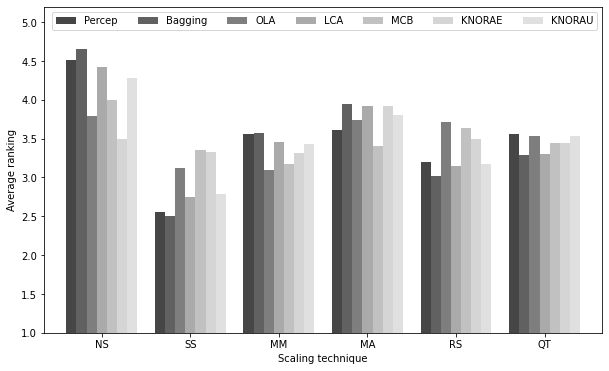

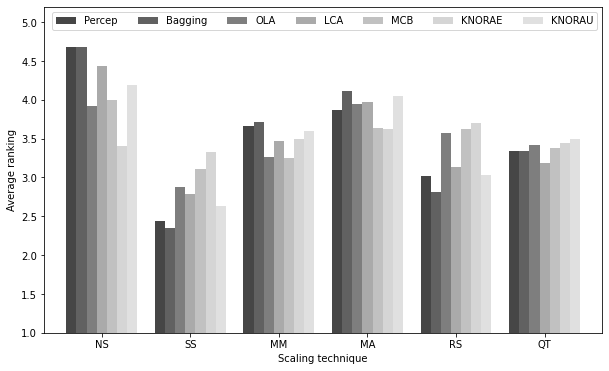

In [42]:
colors = ['#464646', '#616161', '#7e7e7e', '#aaaaaa','#c1c1c1', '#d5d5d5', '#e0e0e0']
for df, metric in [(mean_rank_percep_v_ens_f1, 'f1'), (mean_rank_percep_v_ens_gmean, 'gmean')]:
    ax = df.T.plot.bar(color=colors, width=0.8, ylim=(1,5.2), 
                                              rot=0, ylabel='Average ranking', 
                                              xlabel='Scaling technique')
    ax.legend(ncol = 7)
    ax.figure.set_size_inches(10,6)
    #plt.savefig(f'figs/barplot_avg_rnk_percep_v_ens_{metric}.png', bbox_inches = 'tight')

## CD Diagrams

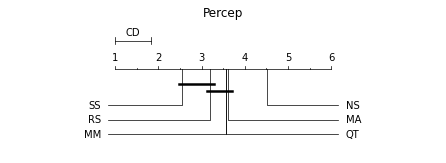

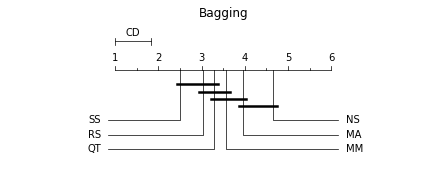

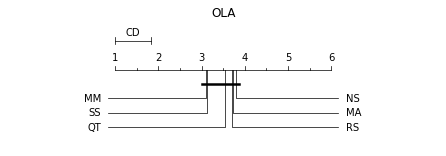

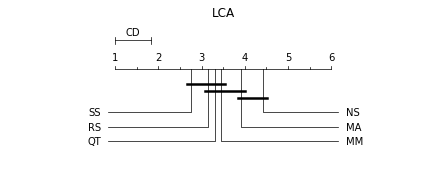

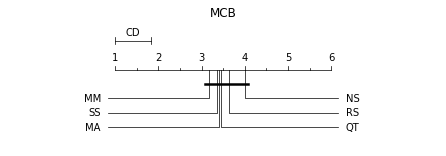

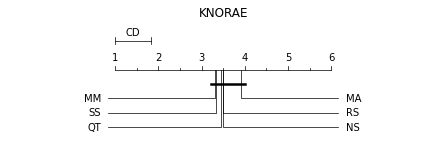

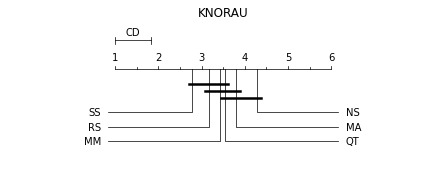

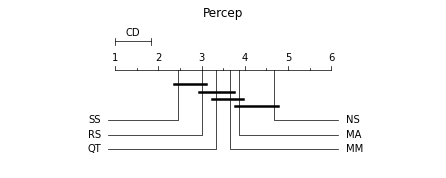

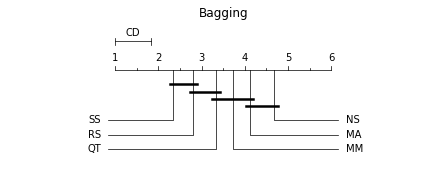

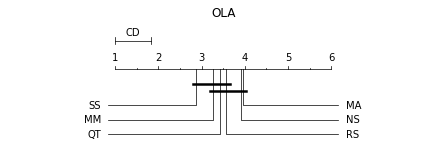

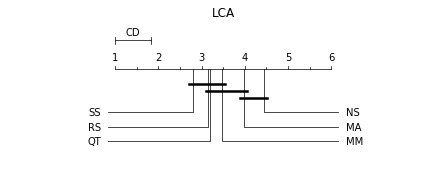

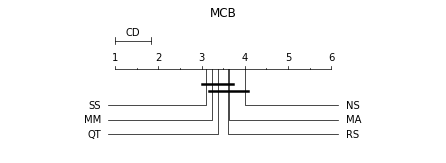

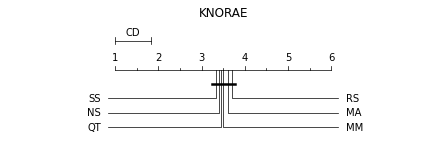

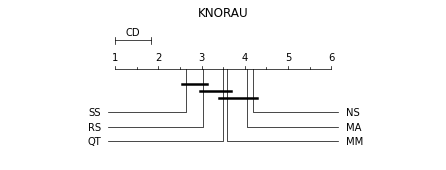

In [43]:
for df, metric in [(mean_rank_percep_v_ens_f1, 'f1'), (mean_rank_percep_v_ens_gmean, 'gmean')]:
    names = list(df.columns)
    for model in df.index:
        avranks = df.loc[model,:].values
        cd = Orange.evaluation.compute_CD(avranks, 82, alpha='0.05', test='nemenyi') #82 datasets
        Orange.evaluation.graph_ranks(avranks, names, cd, width=6, textspace=1.5)
        plt.title(model)
        #plt.savefig(f'figs/CD_diagram_avranks_{model}_{metric}.png', bbox_inches = 'tight')

# Misc

## Bar plots
Bar plots will allow us to assess variation patterns

Defining a function for a custom barplot:

In [44]:
# Defining a function for a custom barplot:
def my_barplot(bars_dct, title, filename):
    # set width of bar
    barWidth = 0.15

    # set height of bar
    bars_ns = bars_dct['No scaling']
    bars_ss = bars_dct['Standard Scaler']
    bars_mms= bars_dct['Min-Max Scaler']
    bars_mas= bars_dct['Max Abs Scaler']
    bars_rs = bars_dct['Robust Scaler']
    bars_qt = bars_dct['Quantile Transformer']

    # Set position of bar on X axis
    r1 = np.arange(len(bars_ns))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]
    
    f, ax = plt.subplots(figsize=(12,7))
    # Make the plot
    #Colors
#     plt.bar(r1, bars_ns, color= '#cfe0e8', width=barWidth, edgecolor='white', label='No scaling')
#     plt.bar(r2, bars_ss, color='#b7d7e8', width=barWidth, edgecolor='white', label='Standard Scaler')
#     plt.bar(r3, bars_mms, color='#87bdd8', width=barWidth, edgecolor='white', label='Min-Max Scaler')
#     plt.bar(r4, bars_mas, color='#daebe8', width=barWidth, edgecolor='white', label='Max Abs Scaler')
#     plt.bar(r5, bars_rs, color='#f1e3dd', width=barWidth, edgecolor='white', label='Robust Scaler')
    #Greys
    plt.bar(r1, bars_ns, color= '#464646', width=barWidth, edgecolor='white', label='No scaling')
    plt.bar(r2, bars_ss, color='#616161', width=barWidth, edgecolor='white', label='Standard Scaler')
    plt.bar(r3, bars_mms, color='#7e7e7e', width=barWidth, edgecolor='white', label='Min-Max Scaler')
    plt.bar(r4, bars_mas, color='#aaaaaa', width=barWidth, edgecolor='white', label='Max Abs Scaler')
    plt.bar(r5, bars_rs, color='#c1c1c1', width=barWidth, edgecolor='white', label='Robust Scaler')
    plt.bar(r6, bars_qt, color='#d5d5d5', width=barWidth, edgecolor='white', label='Quantile Transf.')
#     plt.bar(r1, bars_ns, width=barWidth, edgecolor='white', label='No scaling')
#     plt.bar(r2, bars_ss, width=barWidth, edgecolor='white', label='Standard Scaler')
#     plt.bar(r3, bars_mms, width=barWidth, edgecolor='white', label='Min-Max Scaler')
#     plt.bar(r4, bars_mas, width=barWidth, edgecolor='white', label='Max Abs Scaler')
#     plt.bar(r5, bars_rs,  width=barWidth, edgecolor='white', label='Robust Scaler')


    # Size, titles and labels
    #plt.figure(num=None, figsize=(18, 9), dpi=100, facecolor='w', edgecolor='k')
    ax.set_title(title, fontdict=font)
    #plt.title(title, fontsize=22)
    plt.xlabel('metric', fontweight='bold')
    plt.ylabel('mean', fontweight='bold')

    # Add xticks on the middle of the group bars
    #plt.xticks([r + 2.5*barWidth for r in range(len(bars_ns))], ['acc', 'recall', 'precision', 'f1', 'gmean'])
    plt.xticks([r + 2.5*barWidth for r in range(len(bars_ns))], ['F1', 'G-Mean'])


    # Create legend & Show graphic
    #plt.figure(figsize=(15,8))
    plt.subplots_adjust(bottom=-0.0, top=1.5, right=2)
    plt.grid(True, linewidth=2)
    #plt.legend(fontsize=18, loc='upper center', ncol = 6, bbox_to_anchor=(0.5, 1.10))
    #plt.savefig('figs_'+models_type+'/'+filename, bbox_inches = 'tight')
    plt.show()



In [ ]:
font = {'weight' : 'normal', 'size'   : 75}
plt.rc('font', **font)
#plt.style.use('seaborn-whitegrid')
for model_name in results_df['Model'].unique():
#for model_name in results_df['Model'].unique()[0:1]:
    rfm_df = results_df[results_df['Model'].eq(model_name)]
    bars_dict = {'No scaling':[], 'Standard Scaler': [], 
             'Min-Max Scaler': [], 'Max Abs Scaler': [], 
             'Robust Scaler': [], 'Quantile Transformer': []}
    for metric_str in ['f1_mean', 'gmean_mean']:
    #for metric_str in ['acc_mean', 'recall_mean', 'precision_mean', 'f1_mean', 'gmean_mean']:
        #print('\n\n'+metric_str+':')
        for scaler_str in bars_dict:
            value = rfm_df[rfm_df['Scaling technique'].eq(scaler_str)][metric_str].mean()
            bars_dict[scaler_str].append(value)
            #print('\n...'+scaler_str , value)
    #my_barplot(bars_dict, 'Means of each metric for all datasets with model '+model_name, f'barplot_{model_name}.png')
    my_barplot(bars_dict, model_name, f'barplot_{model_name}.png')
    plt.close('all')

## Model Instability vs. Performance graph

Let's create a graph of model range (representing instability or scale-sensitiveness) vs. model average ranking over the 82 datasets (model performance).


Loading IR dict where the key will be the ds_name and the value will be its IR:

In [45]:
IR_dict = {'abalone-17_vs_7-8-9-10-5-fold': 39.310344827586206,
 'abalone-19_vs_10-11-12-13-5-fold': 49.6875,
 'abalone-20_vs_8-9-10-5-fold': 72.6923076923077,
 'abalone-21_vs_8-5-fold': 40.5,
 'abalone-3_vs_11-5-fold': 32.46666666666667,
 'abalone19-5-fold': 129.4375,
 'abalone9-18-5-fold': 16.404761904761905,
 'cleveland-0_vs_4-5-fold': 12.307692307692308,
 'dermatology-6-5-fold': 16.9,
 'ecoli-0-1-3-7_vs_2-6-5-fold': 39.142857142857146,
 'ecoli-0-1-4-6_vs_5-5-fold': 13.0,
 'ecoli-0-1-4-7_vs_2-3-5-6-5-fold': 10.586206896551724,
 'ecoli-0-1-4-7_vs_5-6-5-fold': 12.28,
 'ecoli-0-1_vs_2-3-5-5-fold': 9.166666666666666,
 'ecoli-0-1_vs_5-5-fold': 11.0,
 'ecoli-0-2-3-4_vs_5-5-fold': 9.1,
 'ecoli-0-2-6-7_vs_3-5-5-fold': 9.181818181818182,
 'ecoli-0-3-4-6_vs_5-5-fold': 9.25,
 'ecoli-0-3-4-7_vs_5-6-5-fold': 9.28,
 'ecoli-0-3-4_vs_5-5-fold': 9.0,
 'ecoli-0-4-6_vs_5-5-fold': 9.15,
 'ecoli-0-6-7_vs_3-5-5-fold': 9.090909090909092,
 'ecoli-0-6-7_vs_5-5-fold': 10.0,
 'ecoli-0_vs_1-5-fold': 1.8571428571428572,
 'ecoli1-5-fold': 3.3636363636363638,
 'ecoli2-5-fold': 5.461538461538462,
 'ecoli3-5-fold': 8.6,
 'ecoli4-5-fold': 15.8,
 'glass-0-1-2-3_vs_4-5-6-5-fold': 3.196078431372549,
 'glass-0-1-4-6_vs_2-5-fold': 11.058823529411764,
 'glass-0-1-5_vs_2-5-fold': 9.117647058823529,
 'glass-0-1-6_vs_2-5-fold': 10.294117647058824,
 'glass-0-1-6_vs_5-5-fold': 19.444444444444443,
 'glass-0-4_vs_5-5-fold': 9.222222222222221,
 'glass-0-6_vs_5-5-fold': 11.0,
 'glass0-5-fold': 2.057142857142857,
 'glass1-5-fold': 1.8157894736842106,
 'glass2-5-fold': 11.588235294117647,
 'glass4-5-fold': 15.461538461538462,
 'glass5-5-fold': 22.77777777777778,
 'glass6-5-fold': 6.379310344827586,
 'haberman-5-fold': 2.7777777777777777,
 'iris0-5-fold': 2.0,
 'kddcup-buffer_overflow_vs_back-5-fold': 73.43333333333334,
 'kddcup-guess_passwd_vs_satan-5-fold': 29.9811320754717,
 'kddcup-land_vs_portsweep-5-fold': 49.523809523809526,
 'kddcup-land_vs_satan-5-fold': 75.66666666666667,
 'kddcup-rootkit-imap_vs_back-5-fold': 100.13636363636364,
 'led7digit-0-2-4-5-6-7-8-9_vs_1-5-fold': 10.972972972972974,
 'lymphography-normal-fibrosis-5-fold': 23.666666666666668,
 'new-thyroid1-5-fold': 5.142857142857143,
 'new-thyroid2-5-fold': 5.142857142857143,
 'page-blocks-1-3_vs_4-5-fold': 15.857142857142858,
 'page-blocks0-5-fold': 8.788908765652952,
 'pima-5-fold': 1.8656716417910448,
 'poker-8-9_vs_5-5-fold': 82.0,
 'poker-8-9_vs_6-5-fold': 58.4,
 'poker-8_vs_6-5-fold': 85.88235294117646,
 'poker-9_vs_7-5-fold': 29.5,
 'segment0-5-fold': 6.015197568389058,
 'shuttle-2_vs_5-5-fold': 66.6734693877551,
 'shuttle-6_vs_2-3-5-fold': 22.0,
 'shuttle-c0-vs-c4-5-fold': 13.869918699186991,
 'shuttle-c2-vs-c4-5-fold': 20.5,
 'vehicle0-5-fold': 3.251256281407035,
 'vehicle1-5-fold': 2.8986175115207375,
 'vehicle2-5-fold': 2.8807339449541285,
 'vehicle3-5-fold': 2.990566037735849,
 'vowel0-5-fold': 9.977777777777778,
 'winequality-red-3_vs_5-5-fold': 68.1,
 'winequality-red-4-5-fold': 29.169811320754718,
 'winequality-red-8_vs_6-5-fold': 35.44444444444444,
 'winequality-red-8_vs_6-7-5-fold': 46.5,
 'winequality-white-3-9_vs_5-5-fold': 58.28,
 'winequality-white-3_vs_7-5-fold': 44.0,
 'winequality-white-9_vs_4-5-fold': 32.6,
 'wisconsin-5-fold': 1.8577405857740585,
 'yeast-0-2-5-6_vs_3-7-8-9-5-fold': 9.141414141414142,
 'yeast-0-2-5-7-9_vs_3-6-8-5-fold': 9.141414141414142,
 'yeast-0-3-5-9_vs_7-8-5-fold': 9.12,
 'yeast-0-5-6-7-9_vs_4-5-fold': 9.352941176470589,
 'yeast-1-2-8-9_vs_7-5-fold': 30.566666666666666,
 'yeast-1-4-5-8_vs_7-5-fold': 22.1,
 'yeast-1_vs_7-5-fold': 14.3,
 'yeast-2_vs_4-5-fold': 9.07843137254902,
 'yeast-2_vs_8-5-fold': 23.1,
 'yeast1-5-fold': 2.4592074592074593,
 'yeast3-5-fold': 8.104294478527608,
 'yeast4-5-fold': 28.098039215686274,
 'yeast5-5-fold': 32.72727272727273,
 'yeast6-5-fold': 41.4}

In [46]:
#Setting up dataframes (one for F1 and another for G-Mean) to store the ranges of all models across the 82 datasets.

f1_cols = ['f1 - NS', 'f1 - SS', 'f1 - MM', 'f1 - MA', 'f1 - RS', 'f1 - QT']
gmean_cols = ['gmean - NS', 'gmean - SS', 'gmean - MM', 'gmean - MA',
       'gmean - RS', 'gmean - QT']

ranges_dict_f1 = {k:[] for k in all_models_names}
ranges_dict_gmean = {k:[] for k in all_models_names}
for rmd in [res_by_mod_dict_mono, res_by_mod_dict_ensemble]:
    for model in list(rmd.keys()):
        for ds_line in range(len(ds_names)):
            range_f1 = rmd[model][f1_cols].iloc[ds_line].max() - rmd[model][f1_cols].iloc[ds_line].min()
            ranges_dict_f1[model].append(range_f1)
            range_gmean = rmd[model][gmean_cols].iloc[ds_line].max() - rmd[model][gmean_cols].iloc[ds_line].min()
            ranges_dict_gmean[model].append(range_gmean)

ranges_df_f1 = pd.DataFrame(ranges_dict_f1)
ranges_df_gmean = pd.DataFrame(ranges_dict_gmean)

In [47]:
# Loading results and concatenating them in a single table
results_df_mono = pd.read_csv('../Results/results_monolithic.csv')
results_df_ensemble = pd.read_csv('../Results/results_ensemble.csv')
results_df_all = pd.concat([results_df_mono, results_df_ensemble], ignore_index=True)
results_df_means_all = results_df_all[['Dataset', 'Scaling technique', 'Model', 'f1_mean', 'gmean_mean']]
results_df_means_all

,Dataset,Scaling technique,Model,f1_mean,gmean_mean
0,glass1-5-fold,No scaling,SVM_lin,0.000000,0.000000
1,glass1-5-fold,Standard Scaler,SVM_lin,0.067974,0.149536
2,glass1-5-fold,Min-Max Scaler,SVM_lin,0.000000,0.000000
3,glass1-5-fold,Max Abs Scaler,SVM_lin,0.000000,0.000000
4,glass1-5-fold,Robust Scaler,SVM_lin,0.044444,0.098827
...,...,...,...,...,...
9835,abalone19-5-fold,Standard Scaler,KNORAU,0.000000,0.000000
9836,abalone19-5-fold,Min-Max Scaler,KNORAU,0.000000,0.000000
9837,abalone19-5-fold,Max Abs Scaler,KNORAU,0.000000,0.000000
9838,abalone19-5-fold,Robust Scaler,KNORAU,0.000000,0.000000


In [48]:
# Creating two tables (F1 and Gmean) containing the max performance (metric value) for each model (columns) for each DS (lines).
# | Dataset | model 1 | model 2 | ... | model n |
# |---------|---------|---------|-----|---------|
# | ds1     | max F1  |  max F1 | ... | max F1  |

max_f1_dict = {k:[] for k in ['Dataset'] + all_models_names}
max_gmean_dict = {k:[] for k in ['Dataset'] + all_models_names}

for ds_name in ds_names:
    max_f1_dict['Dataset'].append(ds_name)
    max_gmean_dict['Dataset'].append(ds_name)
    for model in all_models_names:
        rfm = results_df_means_all[results_df_means_all['Model'].eq(model)]
        max_f1 = rfm[rfm['Dataset'].eq(ds_name)].max()[3] # max f1_mean
        max_gmean = rfm[rfm['Dataset'].eq(ds_name)].max()[4] # max gmean_mean
        max_f1_dict[model].append(max_f1)
        max_gmean_dict[model].append(max_gmean)

max_f1_df = pd.DataFrame(max_f1_dict)
max_gmean_df = pd.DataFrame(max_gmean_dict)

In [49]:
max_f1_df.head(4)

,Dataset,SVM_lin,SVM_RBF,KNN,GNB,GLVQ,LDA,QDA,GP,DT,...,MLP,RF,XGBoost,AdaBoost,Bagging,OLA,LCA,MCB,KNORAE,KNORAU
0,glass1-5-fold,0.350934,0.573735,0.678936,0.618700,0.000000,0.347612,0.615826,0.707050,0.649138,...,0.142647,0.724957,0.734047,0.659950,0.413536,0.702628,0.567478,0.662306,0.735661,0.661578
1,ecoli-0_vs_1-5-fold,0.993220,0.989944,0.989944,0.959396,0.973090,0.989714,0.814444,0.989584,0.981900,...,0.966405,0.993220,0.982304,0.978393,0.986307,0.986077,0.982804,0.985813,0.978670,0.986307
2,wisconsin-5-fold,0.958458,0.958675,0.960520,0.951510,0.958417,0.947211,0.933936,0.956139,0.917292,...,0.960990,0.958755,0.954055,0.936684,0.956482,0.948358,0.948069,0.945584,0.943581,0.956737
3,pima-5-fold,0.633748,0.633632,0.604088,0.672363,0.482441,0.633759,0.649695,0.643636,0.582497,...,0.000000,0.642424,0.624524,0.618598,0.646443,0.629052,0.503028,0.641083,0.588944,0.647101


In [50]:
# Now, the average rankings for each model are:
avg_rankings_f1 = max_f1_df.rank(axis='columns', numeric_only=True, ascending=False).mean()
avg_rankings_gmean = max_gmean_df.rank(axis='columns', numeric_only=True, ascending=False).mean()

# And the mean ranges are:
mean_ranges_f1 = ranges_df_f1.mean()
mean_ranges_gmean = ranges_df_gmean.mean()

In [51]:
ranking_vs_range_f1_df = pd.concat({'Average ranking':avg_rankings_f1, 'Mean range':mean_ranges_f1}, axis=1)
ranking_vs_range_gmean_df = pd.concat({'Average ranking':avg_rankings_gmean, 'Mean range':mean_ranges_gmean}, axis=1)
ranking_vs_range_gmean_df

,Average ranking,Mean range
SVM_lin,11.810976,0.215634
SVM_RBF,11.506098,0.338933
KNN,9.457317,0.158431
GNB,11.115854,0.093882
GLVQ,18.091463,0.153668
LDA,11.250000,0.091853
QDA,12.042683,0.224765
GP,8.902439,0.380097
DT,10.176829,0.012894
Percep,9.670732,0.314983


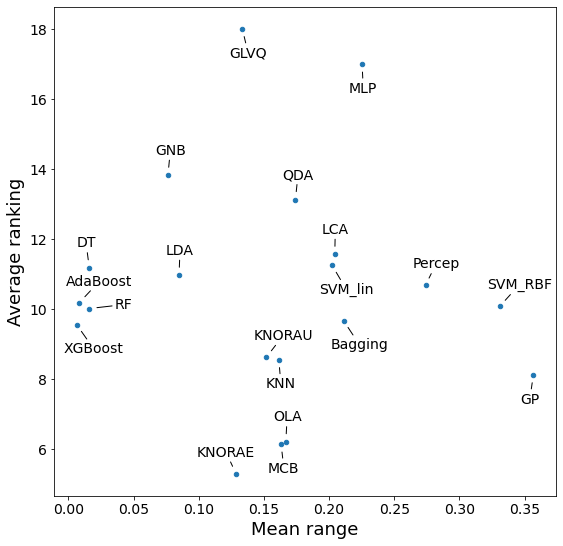

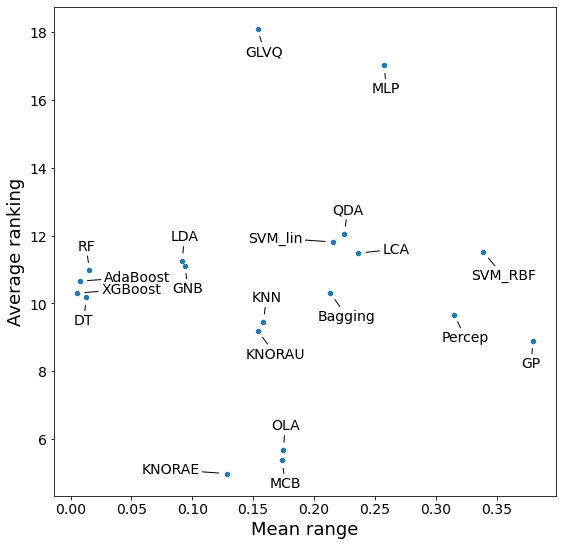

In [52]:
# For F1:
df = ranking_vs_range_f1_df
ax = df.plot(x='Mean range', y='Average ranking', kind='scatter', figsize=(9,9), fontsize=14)
ax.set_xlabel(ax.get_xlabel(), fontdict={'fontsize':18})
ax.set_ylabel(ax.get_ylabel(), fontdict={'fontsize':18})
# Annotations:
names = list(df.index)
y = list(df['Average ranking'])
x = list(df['Mean range'])
for i in range(len(names)):
    if names[i] in ['GNB', 'QDA', 'LCA', 'DT', 'LDA', 'OLA']: # annotate above:
        ax.annotate(text=names[i], xy=(x[i], y[i]), xytext=(x[i]-0.01, y[i]+0.6), fontsize=14,
                    arrowprops = dict(arrowstyle="-", connectionstyle='arc3',
                                     shrinkA=1, shrinkB=8))
    elif names[i] in ['Percep', 'SVM_RBF', 'AdaBoost','KNORAU']: # annotate above:
        ax.annotate(text=names[i], xy=(x[i], y[i]), xytext=(x[i]-0.01, y[i]+0.5), fontsize=14,
                    arrowprops = dict(arrowstyle="-", connectionstyle='arc3',
                                     shrinkA=1, shrinkB=8))
    elif names[i] in ['RF']:
        ax.annotate(text=names[i], xy=(x[i], y[i]), xytext=(x[i]+0.02, y[i]), fontsize=14,
                    arrowprops = dict(arrowstyle="-", connectionstyle='arc3',
                                     shrinkA=1, shrinkB=8))
    elif names[i] in ['KNORAE']: # annotate above:
        ax.annotate(text=names[i], xy=(x[i], y[i]), xytext=(x[i]-0.03, y[i]+0.5), fontsize=14,
                    arrowprops = dict(arrowstyle="-", connectionstyle='arc3',
                                     shrinkA=1, shrinkB=8))
    else: # annotate under:
        ax.annotate(text=names[i], xy=(x[i], y[i]), xytext=(x[i]-0.01, y[i]-0.8), fontsize=14,
                    arrowprops = dict(arrowstyle="-", connectionstyle='arc3',
                                     shrinkA=1, shrinkB=8))
#plt.savefig(f'figs/Ranking_vs_Range_f1.png', bbox_inches = 'tight')

# For Gmean: 
df = ranking_vs_range_gmean_df
ax = df.plot(x='Mean range', y='Average ranking', kind='scatter', figsize=(9,9), fontsize=14)
ax.set_xlabel(ax.get_xlabel(), fontdict={'fontsize':18})
ax.set_ylabel(ax.get_ylabel(), fontdict={'fontsize':18})
# Annotations:
names = list(df.index)
y = list(df['Average ranking'])
x = list(df['Mean range'])
for i in range(len(names)):
    if names[i] in ['RF', 'LDA', 'QDA', 'KNN', 'OLA']: # annotate above:
        ax.annotate(text=names[i], xy=(x[i], y[i]), xytext=(x[i]-0.01, y[i]+0.6), fontsize=14,
                    arrowprops = dict(arrowstyle="-", connectionstyle='arc3',
                                     shrinkA=1, shrinkB=8))
    elif names[i] in ['AdaBoost', 'XGBoost', 'LCA']: # annotate to the right
        ax.annotate(text=names[i], xy=(x[i], y[i]), xytext=(x[i]+0.02, y[i]), fontsize=14,
                    arrowprops = dict(arrowstyle="-", connectionstyle='arc3',
                                     shrinkA=1, shrinkB=8))
    elif names[i] in ['SVM_lin', 'KNORAE']: # annotate to the left
        ax.annotate(text=names[i], xy=(x[i], y[i]), xytext=(x[i]-0.07, y[i]), fontsize=14,
                    arrowprops = dict(arrowstyle="-", connectionstyle='arc3',
                                     shrinkA=1, shrinkB=8))
    else: # annotate under:
        ax.annotate(text=names[i], xy=(x[i], y[i]), xytext=(x[i]-0.01, y[i]-0.8), fontsize=14,
                    arrowprops = dict(arrowstyle="-", connectionstyle='arc3',
                                     shrinkA=1, shrinkB=8))
#plt.savefig(f'figs/Ranking_vs_Range_gmean.png', bbox_inches = 'tight')